In [1]:
!pip install patchify
import os
import gc

In [2]:
# import the required libraries
import os; import cv2; import random
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.utils import to_categorical
from keras.models import load_model, Model
from tensorflow.keras import backend as K
from keras.layers import Flatten
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, AveragePooling2D
from sklearn.model_selection import train_test_split
import keras

In [3]:
# user defined functions for training
@keras.saving.register_keras_serializable()
def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

@keras.saving.register_keras_serializable()
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

@keras.saving.register_keras_serializable()
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow((1 - y_pred), gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return focal_loss_fixed

@keras.saving.register_keras_serializable()
def combined_loss(y_true, y_pred):
    return 100 * dice_loss(y_true, y_pred) + focal_loss()(y_true, y_pred)

### model architecture

In [4]:
# defining a simple UNET model class
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    # inputs
    s = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    # shrinking layers
    c1 = Conv2D(16, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = Conv2D(128, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    c5 = Conv2D(256, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c5)
    # expansion layers
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c6)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c7)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c8)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='leaky_relu', kernel_initializer='he_normal', padding='same')(c9)
    # outputs
    o = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[s], outputs=[o])
    return model

### data loading and preprocessing

In [5]:
# define the scaler, patch size and the root directory
scaler = MinMaxScaler()
root_directory = '/kaggle/input/semantic-segmentation-dataset/Semantic segmentation dataset'
patch_size = 256

In [6]:
# patchify the images
image_set = []
mask_set = []
image_files = []
mask_files = []

# go through the images
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        image_files += sorted([os.path.join(path, f) for f in files if f.endswith(".jpg")])
    elif dirname == 'masks':
        mask_files += sorted([os.path.join(path, f) for f in files if f.endswith(".png")])

for img_path, mask_path in zip(image_files, mask_files):
    # process image and mask simultaneously
    image = cv2.imread(img_path, 1)
    mask = cv2.imread(mask_path, 1)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    SIZE_X = (image.shape[1] // patch_size) * patch_size
    SIZE_Y = (image.shape[0] // patch_size) * patch_size
    image = Image.fromarray(image).crop((0, 0, SIZE_X, SIZE_Y))
    mask = Image.fromarray(mask).crop((0, 0, SIZE_X, SIZE_Y))
    image = np.array(image)
    mask = np.array(mask)
    patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
    patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            # process image patch
            single_patch_img = patches_img[i, j, :, :]
            single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
            single_patch_img = single_patch_img[0]
            image_set.append(single_patch_img)
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = single_patch_mask[0]
            mask_set.append(single_patch_mask)
    gc.collect()

In [7]:
# convert hexadecimal color labels into (r, g, b)
def hex_to_rgb(hex):
    return np.array(tuple(int(hex[i:i+2], 16) for i in (0, 2, 4)))
Building = hex_to_rgb('3C1098')
Land = hex_to_rgb('8429F6')
Road = hex_to_rgb('6EC1E4')
Vegetation = hex_to_rgb('FEDD3A')
Water = hex_to_rgb('E2A929')
Unlabeled = hex_to_rgb('9B9B9B')

In [8]:
# convert rgb to a label
def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    label_seg = label_seg[:,:,0]
    return label_seg

# convert all masks into labels
mask_dataset = np.array(mask_set)
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)
del mask_dataset

# check the unique labels
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


In [9]:
# convert images into a numpy array
image_dataset = np.array(image_set)

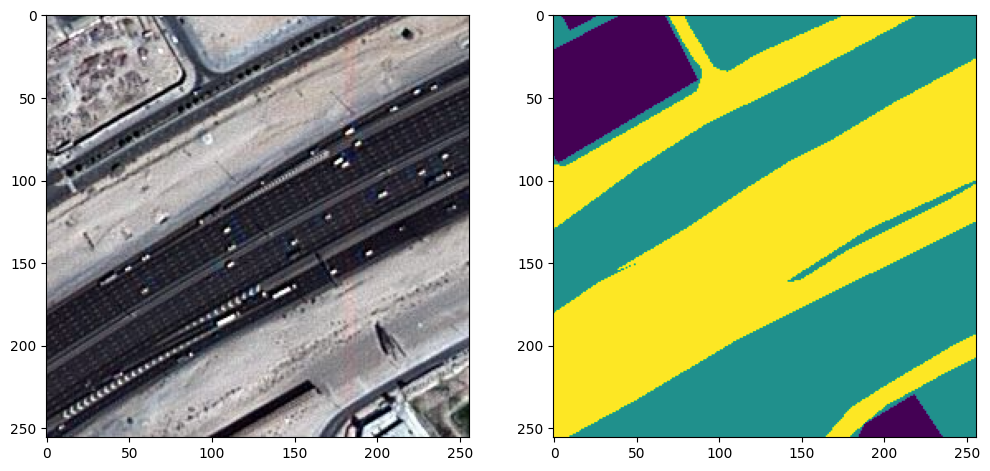

In [10]:
# plotting one image for sanity check
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [11]:
# convert all labels into one hot encoded labels
n_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes=n_classes)
del labels
gc.collect()

6454

In [12]:
# split the dataset into train and val datasets
X_train, X_test, y_train, y_test = train_test_split(np.array(image_set), labels_cat, test_size = 0.20, random_state = 42)
del image_set, mask_set, labels_cat
gc.collect()

# get the dimensions of the image
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

### only for training

In [13]:
# define the model and the metrics for it
metrics=['accuracy', jaccard_coef]
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
model = get_model()
model.compile(optimizer='adam', loss=combined_loss, metrics=metrics)
# model.summary()

In [14]:
# train on the model
with tf.device('/device:GPU:0'):
  history = model.fit(X_train, y_train,
                      batch_size = 32,
                      verbose=1,
                      epochs=120,
                      validation_data=(X_test, y_test),
                      shuffle=False)

Epoch 1/120


I0000 00:00:1731340350.716069      79 service.cc:145] XLA service 0x78b6042259e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731340350.716180      79 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-11-11 15:52:52.267187: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,256,256]{3,2,1,0}, f32[32,16,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-11 15:52:52.821016: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.55406216s
Trying algorithm eng0{} for conv 

 1/33 ━━━━━━━━━━━━━━━━━━━━ 19:46 37s/step - accuracy: 0.1222 - jaccard_coef: 0.0861 - loss: 100.0131

I0000 00:00:1731340381.203149      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.4490 - jaccard_coef: 0.2719 - loss: 72.4893 - val_accuracy: 0.5588 - val_jaccard_coef: 0.3796 - val_loss: 58.2947
Epoch 2/120
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.6018 - jaccard_coef: 0.4033 - loss: 53.0573 - val_accuracy: 0.6303 - val_jaccard_coef: 0.4560 - val_loss: 48.3638
Epoch 3/120
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.6784 - jaccard_coef: 0.4849 - loss: 43.8134 - val_accuracy: 0.6530 - val_jaccard_coef: 0.4768 - val_loss: 46.3166
Epoch 4/120
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.7147 - jaccard_coef: 0.5316 - loss: 39.2655 - val_accuracy: 0.6493 - val_jaccard_coef: 0.4715 - val_loss: 46.1353
Epoch 5/120
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.7294 - jaccard_coef: 0.5435 - loss: 37.6849 - val_accuracy: 0.6584 - val_jaccard_coef: 0.4822 - val_loss: 45.6797
Epoch 6/120
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.7543 - jaccard_coef: 0.5646 - loss: 35.45

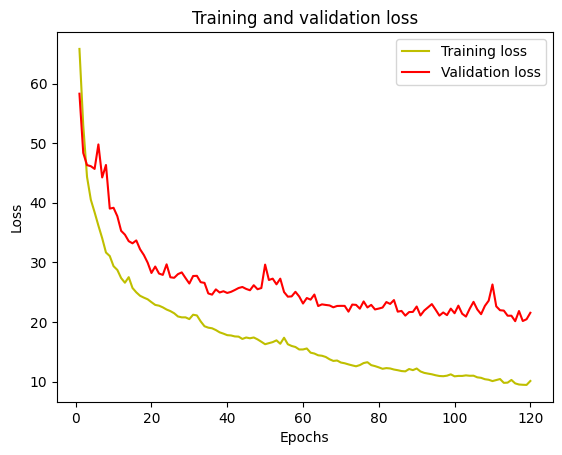

In [15]:
# plot the loss vs epochs
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

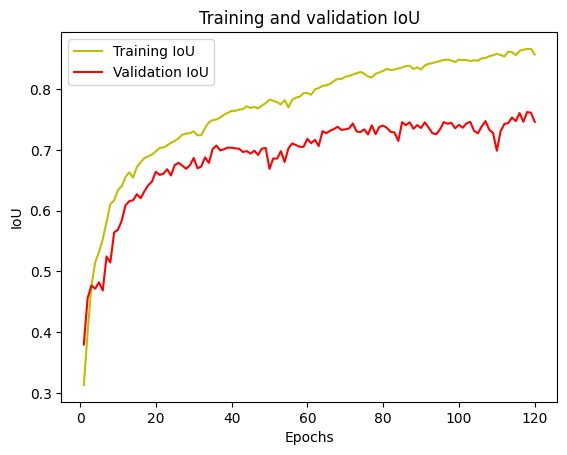

In [16]:
# plot the jaccard coefficient vs epochs
acc = history.history['jaccard_coef']
val_acc = history.history['val_jaccard_coef']
plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [17]:
# save the trained model
os.makedirs('/kaggle/working', exist_ok=True)
model.save('/kaggle/working/model.keras')

### for testing

In [18]:
# import the required libraries
import os; import cv2; import random
import numpy as np
from matplotlib import pyplot as plt
# from patchify import patchify
from PIL import Image
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.utils import to_categorical
from keras.models import load_model, Model
from tensorflow.keras import backend as K
from keras.layers import Flatten
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, AveragePooling2D
from sklearn.model_selection import train_test_split
import keras

In [19]:
# load the saved model
model2 = load_model("/kaggle/input/semsegmodel/tensorflow2/default/1/model.keras")
# model2 = load_model("/kaggle/working/model.keras")

In [20]:
# # predicted results
# y_pred=model2.predict(X_test)
# y_pred_argmax=np.argmax(y_pred, axis=3)
# y_test_argmax=np.argmax(y_test, axis=3)

In [21]:
# # calculate the mean IoU
# n_classes = 6
# IOU_keras = MeanIoU(num_classes=n_classes)
# IOU_keras.update_state(y_test_argmax, y_pred_argmax)
# print("Mean IoU =", IOU_keras.result().numpy())

In [22]:
from tensorflow.keras.utils import img_to_array, load_img
image_dir = "/kaggle/input/semseg-test-img/test_images"
all_images = []
for img_file in os.listdir(image_dir):
    img_path = os.path.join(image_dir, img_file)
    if img_path.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
        img = load_img(img_path, target_size=(256, 256))
        img_array = img_to_array(img)
        all_images.append(img_array)
dataset = np.array(all_images).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


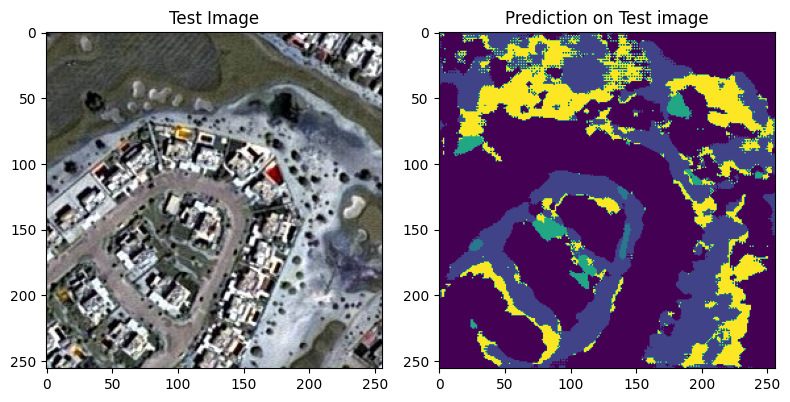

In [23]:
# show a random image
test_img_number = random.randint(0, len(dataset)-1)
test_img = dataset[test_img_number]
# ground_truth=y_test_argmax[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model2.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('Test Image')
plt.imshow(test_img)
plt.subplot(222)
plt.title('Prediction on Test image')
plt.imshow(predicted_img)
plt.tight_layout(); plt.show()

In [24]:
# rgb_pred_img = np.zeros((predicted_img.shape[0], predicted_img.shape[1], 3), dtype=np.uint8)
# rgb_pred_img[predicted_img == 0] = Building
# rgb_pred_img[predicted_img == 1] = Land
# rgb_pred_img[predicted_img == 2] = Road
# rgb_pred_img[predicted_img == 3] = Vegetation
# rgb_pred_img[predicted_img == 4] = Water
# rgb_pred_img[predicted_img == 5] = Unlabeled

In [25]:
# plt.imshow(rgb_pred_img)
# plt.show()